In [1]:
!pip uninstall -y jax jaxlib
!pip install -q corner numpyro

Uninstalling jax-0.2.8:
  Successfully uninstalled jax-0.2.8
Uninstalling jaxlib-0.1.59:
  Successfully uninstalled jaxlib-0.1.59


In [2]:
!wget -nc https://users.flatironinstitute.org/~apricewhelan/data/edr3/edr3-rv-good-plx-result.fits.gz

File ‘edr3-rv-good-plx-result.fits.gz’ already there; not retrieving.



In [3]:
%matplotlib inline

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [5]:
plt.style.use("default")
plt.rcParams["savefig.dpi"] = 100
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Liberation Sans"]
plt.rcParams["font.cursive"] = ["Liberation Sans"]
plt.rcParams["mathtext.fontset"] = "custom"
get_ipython().magic('config InlineBackend.figure_format = "retina"')

In [6]:
columns = [
    "random_index",
    "parallax",
    "parallax_error",
    "phot_g_mean_mag",
    "bp_rp",
    "dr2_rv_nb_transits",
    "dr2_radial_velocity_error"
]

with fits.open("edr3-rv-good-plx-result.fits.gz") as f:
    data = f[1].data

In [7]:
m = np.isfinite(data["phot_g_mean_mag"])
m &= data["phot_g_mean_mag"] < 12
m &= 8 < data["phot_g_mean_mag"]
data = data[m]

In [8]:
m = np.isfinite(data["bp_rp"])
m &= data["bp_rp"] < 3
m &= 0.5 < data["bp_rp"]
m &= np.isfinite(data["dr2_radial_velocity_error"])
m &= data["dr2_rv_nb_transits"] > 3
data = data[m]

In [9]:
num_transit = np.ascontiguousarray(data["dr2_rv_nb_transits"], dtype=np.int32)
sample_variance = 2 * num_transit * (np.ascontiguousarray(data["dr2_radial_velocity_error"], dtype=np.float32) ** 2 - 0.11 ** 2) / np.pi
mag = np.ascontiguousarray(data["phot_g_mean_mag"], dtype=np.float32)
color = np.ascontiguousarray(data["bp_rp"], dtype=np.float32)
plx = np.ascontiguousarray(data["parallax"], dtype=np.float32)

len(data)

1612387

In [10]:
from jax.config import config

config.update("jax_enable_x64", True)

from jax import random
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO


def model(num_transit, sample_variance):
    log_sigma0 = numpyro.sample("log_sigma0", dist.Normal(0.0, 10.0))
    log_dsigma = numpyro.sample("log_dsigma", dist.Normal(0.0, 10.0),
                                    sample_shape=(len(sample_variance),))
    sigma2 = jnp.exp(2 * log_sigma0) + jnp.exp(2 * log_dsigma)
    stat = sample_variance * (num_transit - 1) / sigma2
    numpyro.sample("obs", dist.Chi2(num_transit - 1), obs=stat)

def guide(num_transit, sample_variance):
    mu_log_sigma0 = numpyro.param("mu_log_sigma0", 0.5 * np.log(np.median(sample_variance)))
    sigma_log_sigma0 = numpyro.param("sigma_log_sigma0", 1.0,
                                     constraint=dist.constraints.positive)
    
    mu_log_dsigma = numpyro.param("mu_log_dsigma", 0.5 * np.log(sample_variance))
    sigma_log_dsigma = numpyro.param("sigma_log_dsigma", np.ones_like(sample_variance),
                                     constraint=dist.constraints.positive)
    
    numpyro.sample("log_sigma0", dist.Normal(mu_log_sigma0, sigma_log_sigma0))
    numpyro.sample("log_dsigma", dist.Normal(mu_log_dsigma, sigma_log_dsigma))

optimizer = numpyro.optim.Adam(step_size=0.05)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

In [11]:
num_per = 1000
mag_bins = np.linspace(mag.min(), mag.max(), 8)
color_bins = np.exp(np.linspace(np.log(color.min()), np.log(color.max()), 10))
inds = np.arange(len(data))

mu = np.empty((len(mag_bins) - 1, len(color_bins) - 1))
sigma = np.empty_like(mu)

for n in range(len(mag_bins) - 1):
    for m in range(len(color_bins) - 1):
        mask = mag_bins[n] <= mag
        mask &= mag <= mag_bins[n + 1]
        mask &= color_bins[m] <= color
        mask &= color <= color_bins[m + 1]
        masked_inds = np.random.choice(inds[mask], size=num_per, replace=False)

        svi_result = svi.run(random.PRNGKey(n + m), 5000, num_transit[masked_inds], sample_variance[masked_inds])
        params = svi_result.params
        mu[n, m] = params["mu_log_sigma0"]
        sigma[n, m] = params["sigma_log_sigma0"]

100%|██████████| 5000/5000 [00:10<00:00, 457.58it/s, init loss: 8078.0991, avg. loss [4751-5000]: 3863.7924]


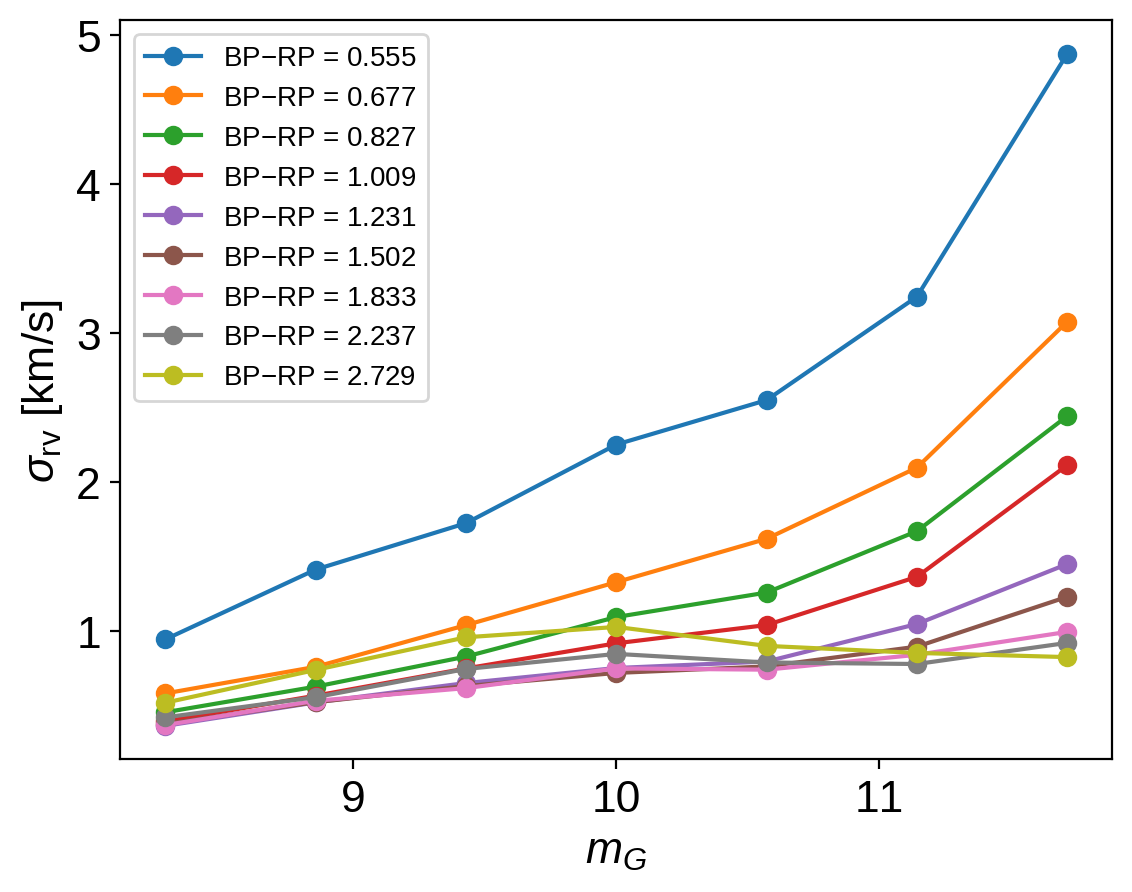

In [12]:
for m in range(len(color_bins) - 1):
    plt.plot(0.5 * (mag_bins[1:] + mag_bins[:-1]), np.exp(mu[:, m]), "o-",
             label="BP$-$RP = {0:.3f}".format(0.5*(color_bins[m] + color_bins[m + 1])))
plt.ylabel(r"$\sigma_\mathrm{rv}$ [km/s]")
plt.xlabel("$m_G$")
plt.legend(fontsize=10)

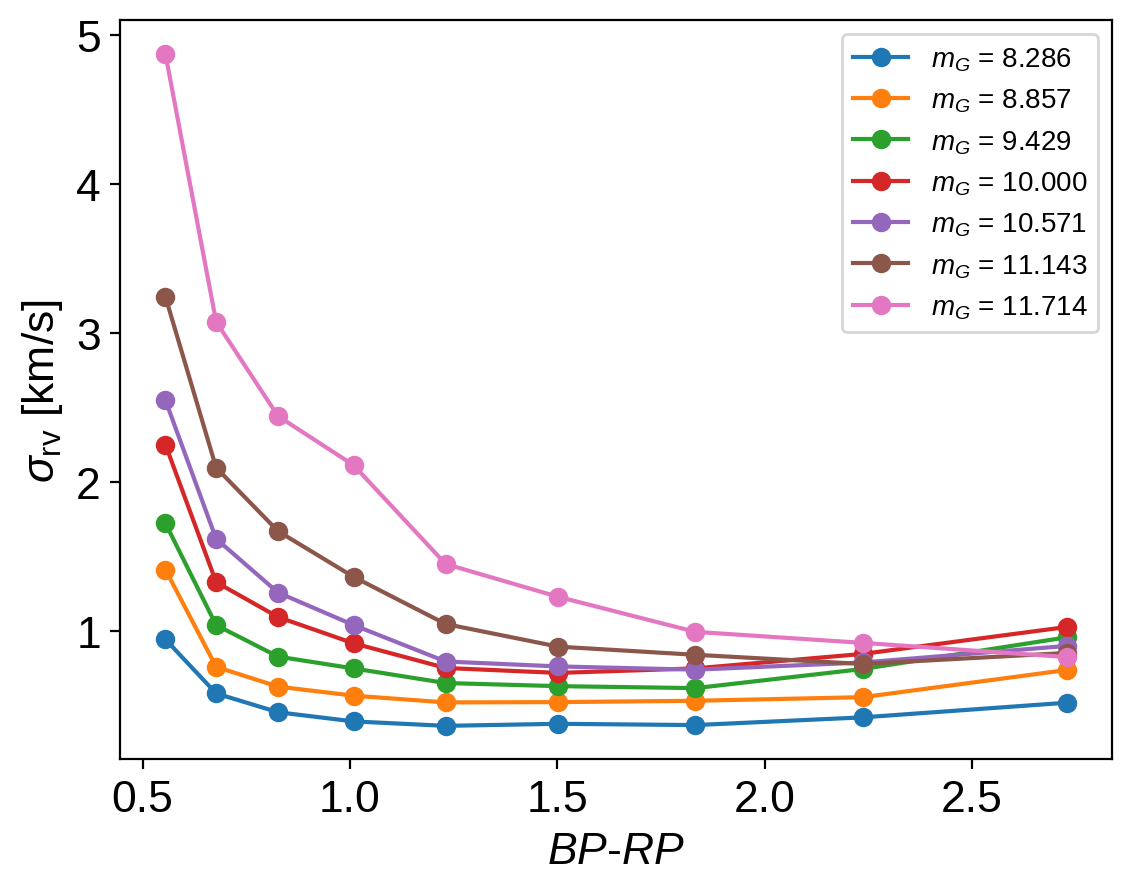

In [14]:
for n in range(len(mag_bins) - 1):
    plt.plot(0.5 * (color_bins[1:] + color_bins[:-1]), np.exp(mu[n]), "o-",
             label="$m_G$ = {0:.3f}".format(0.5*(mag_bins[n] + mag_bins[n + 1])))
plt.ylabel(r"$\sigma_\mathrm{rv}$ [km/s]")
plt.xlabel("$BP$-$RP$")
plt.legend(fontsize=10);